<a href="https://colab.research.google.com/github/Rutu07/Insight-Extraction-of-Amazon-Product-Reviews-NLP--Topic-Modeling-/blob/main/Sentiment_Analysis_of_Amazon_Product_Reviews_using_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- GPU (Graphics Processing Unit) enable paralle processing of complex tasks. Lot of computing power is required to train Neural Networks on thousands/millions of records and GPUs provide this computing power. 
- Traditional CPUs are capable of completing task in sequential manner along with their multi-cores, however GPUs process many parts of data simultaneously.

In [ ]:
import torch
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth',200)
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

#library for progress bar
from tqdm import notebook
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# importing nn module
import torch.nn as nn

#library for computing class weights
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import classification_report


import time
import datetime

from google.colab import drive

Runtime->Change RunTIme-> Select GPU in Hardware Accelrator


In [ ]:
# Checking if GPU is available. 
if torch.cuda.is_available():
  device=torch.device('cuda')

In [ ]:
print(device)
torch.cuda.get_device_name(0)
# Current GPU is Tesla T4

cuda


'Tesla T4'

### Step 2: Installing Hugging Face's Transformers Library
- Hugging face is one of the most popular NLP library and provides a wide range of transformer-based models such as BERT, GPT-2, Roberta, and so on.


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 9.5 MB/s eta 0:00:00


### Step 3: Installing BertModel 

- BERT uncased: This model was trained on lower case text data. Other types of pre-trained models, can be found at https://huggingface.co/models


In [ ]:
from transformers.models.bert.modeling_bert import BertModel
# Import BERT pretrained module
from transformers import BertModel

#Download uncased bert base model
bert=BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Print BERT arcitecture
print(bert)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

### Step 4: Importing BERT tokenizer
It tencodes text into positional encodings combined with word(contextual) embeddings. The tokenizer version present in transformers library is the fast version.

In [ ]:
from transformers.models.bert.tokenization_bert_fast import BertTokenizerFast
# importing BERT tokenizer 
tokenizer=BertTokenizerFast.from_pretrained('bert-base-uncased',do_lower_case=True)


**Steps occuring in Input Encoding**

1. Tokenization
2. Special Tokens
  * Prepending [CLS] token at the start of the sequence
  * Appneding [SEP] token at the end of the seqence
3. Pad sequences
4. Convert tokens into integers(vector embeddings)
5. Create attention masks to indicate non padded elements.




In [ ]:
text='Jim Henson was a puppeteer'
sentence_id=tokenizer.encode(text,
                             # add special character tokens
                             add_special_tokens=True,
                             # Specifying maximum length for any input sequences
                             max_length=10,
                             # if exceeeding 10, then it will be truncated, if <10, then it will be padded.
                             truncation=True,
                             # add pad tokens to the right side of the sequence
                             pad_to_max_length='right'
                             )
print("Integer Sequence:{}".format(sentence_id))

Integer Sequence:[101, 3958, 27227, 2001, 1037, 13997, 11510, 102, 0, 0]


/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


- [CLS] is represented by 101 where as [SEP] is represented by 102. Two zeros at the end represent padded elements to have a seuqnce of length 10.

In [ ]:
# converting integers back to text
print("Tokenizer Text: ",tokenizer.convert_ids_to_tokens(sentence_id))

Tokenizer Text:  ['[CLS]', 'jim', 'henson', 'was', 'a', 'puppet', '##eer', '[SEP]', '[PAD]', '[PAD]']


- Note that puppeteer was not a part of Bert tokenizer vocabulary while training. It doesn't have any word embedding for word puppeteer. Hence it was split into known part 'puppet' and unknown part '##eer'. The tokenizer has embeddings for both the tokens. ## represents that the token is a sub word. This is how BERT tokenizer handles unkwown words.

- Using tokenizer.decode(), this can be decoded back into original sentence

In [ ]:
decoded=tokenizer.decode(sentence_id)
print('Decoded String:{}'.format(decoded))

Decoded String:[CLS] jim henson was a puppeteer [SEP] [PAD] [PAD]


- Masking needs to be done to avoid performing attention on padding token indices.
- mask value=1 for tokens and 0 for unmasked tokens

In [ ]:
att_mask=[int(tok>0) for tok in sentence_id]
print(att_mask)

[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]


**Understanding Input and Output of BERT Tokenizer**


- To understand unsqueeze() and squeeze() function: https://stackoverflow.com/questions/57237352/what-does-unsqueeze-do-in-pytorch


In [ ]:
# convert lists to tensors
# torch.tensor creates a tensor of given data
sent_id=torch.tensor(sentence_id)
attn_mask=torch.tensor(att_mask)
print('Shape of sentence_id before reshaping is: {}'.format(sent_id.shape))
print('Shape of sentence_id before reshaping is: {}'.format(attn_mask.shape))
print('\n')
# reshaping tensor in form of batch,text length
sent_id=sent_id.unsqueeze(0)
attn_mask=attn_mask.unsqueeze(0)
print('Shape of sentence_id after reshaping is: {}'.format(sent_id.shape))
print('Shape of sentence_id after reshaping is: {}'.format(attn_mask.shape))
print('\n')
# reshaped tensor
print(sent_id)


Shape of sentence_id before reshaping is: torch.Size([10])
Shape of sentence_id before reshaping is: torch.Size([10])


Shape of sentence_id after reshaping is: torch.Size([1, 10])
Shape of sentence_id after reshaping is: torch.Size([1, 10])


tensor([[  101,  3958, 27227,  2001,  1037, 13997, 11510,   102,     0,     0]])


- Here we can see that list of integers has beem converted into pytorch tensor of dimension (1,10)

In [ ]:
# passing integer sequence and attention mask tensor to BERT model
outputs=bert(sent_id,attention_mask=attn_mask)


In [ ]:
# Unpacking the output of BERT model

# all_hidden_states is a collection of all the output vectors/ hidden states (of encoder) at each timestamps or position of the BERT model
all_hidden_states=outputs[0]

print(all_hidden_states.shape)
print(all_hidden_states)

torch.Size([1, 10, 768])
tensor([[[-0.2531,  0.2038, -0.3862,  ..., -0.3034,  0.6197,  0.2373],
         [-0.2323, -0.0044, -0.5479,  ...,  0.0765,  0.8122, -0.4710],
         [ 0.2590,  0.7140, -0.5438,  ..., -0.3774,  0.9987,  0.5400],
         ...,
         [ 0.7873,  0.3299, -0.0351,  ...,  0.2932, -0.5141,  0.0308],
         [-0.5547, -0.3669, -0.1106,  ...,  0.2593,  0.5321, -0.3871],
         [-0.5461, -0.2414, -0.2111,  ...,  0.3100,  0.5863, -0.3467]]],
       grad_fn=<NativeLayerNormBackward0>)


- 1 because we have only one senetence(sequence)
- 10 because we have maximum of 10 words in each sequence. For shorter sentences, 0 are padded at right side.
- 768 is the default dim of BERT output vector where every word out of 10 words is represented into a vector of 768 columns

In [ ]:
# this output contains output vector against the CLS token only (at the first position of BERT model)
# this output vector encodes the entire input sequence 

cls_hidden_state=outputs[1]
 
print(cls_hidden_state.shape)
print(cls_hidden_state)

torch.Size([1, 768])
tensor([[-0.8767, -0.4109, -0.1220,  0.4494,  0.1945, -0.2698,  0.8316,  0.3127,
          0.1178, -1.0000, -0.1561,  0.6677,  0.9891, -0.3451,  0.8812, -0.6753,
         -0.3079, -0.5580,  0.4380, -0.4588,  0.5831,  0.9956,  0.4467,  0.2863,
          0.3924,  0.6864, -0.7513,  0.9043,  0.9436,  0.8207, -0.6493,  0.3524,
         -0.9919, -0.2295, -0.0742, -0.9936,  0.3698, -0.7558,  0.0792, -0.2218,
         -0.8637,  0.4711,  0.9997, -0.4368,  0.0404, -0.3498, -1.0000,  0.2663,
         -0.8711,  0.0508,  0.0505, -0.1634,  0.1716,  0.4363,  0.4330, -0.0333,
         -0.0416,  0.2206, -0.2568, -0.6122, -0.5916,  0.2569, -0.2622, -0.9041,
          0.3221, -0.2394, -0.2634, -0.3454, -0.0723,  0.0081,  0.8297,  0.2279,
          0.1614, -0.6555, -0.2062,  0.3280, -0.4016,  1.0000, -0.0952, -0.9874,
         -0.0400,  0.0717,  0.3675,  0.3373, -0.3710, -1.0000,  0.4479, -0.1722,
         -0.9917,  0.2677,  0.4844, -0.2207, -0.3207,  0.3715, -0.2171, -0.2522,
       

### Step 5: Data Preparation
#### 5.1 Loading dataset and selecting important columns



In [ ]:
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
df=pd.read_csv('/content/gdrive/MyDrive/translated_cleaned_data_1_unsupervised.csv')
df.head()

,Unnamed: 0,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0.1.1,reviewerID,asin,reviewText,overall,summary,title,brand,review_length,cleaned_reviewText,lemmatized_review_length,target,y
0,0,0,0,0,A30TL5EWN6DFXT,120401325X,Looks Good Looks Good They look good and stick good! I just don't like the rounded shape because I was always bumping it and Siri kept popping up and it was irritating. I just won't buy a produ...,4,Looks Good,NaN,NaN,41,looks good look good look good stick good not like round shape always bump siri keep pop irritate not buy product like,22,Good,1
1,1,1,1,1,ASY55RVNIL0UD,120401325X,Really great product. Really great product. These stickers work like the review says they do. They stick on great and they stay on the phone. They are super stylish and I can share them with my...,5,Really great product.,NaN,NaN,38,really great product really great product sticker work like review say stick great stay phone super stylish share sister,19,Good,1
2,2,2,2,2,A2TMXE2AFO7ONB,120401325X,LOVE LOVE LOVE LOVE LOVE LOVE These are awesome and make my phone look so stylish! I have only used one so far and have had it on for almost a year! CAN YOU BELIEVE THAT! ONE YEAR!! Great quality!,5,LOVE LOVE LOVE,NaN,NaN,40,love love love love love love awesome make phone look stylish use one far almost year believe one year great quality,21,Good,1
3,3,3,3,3,AWJ0WZQYMYFQ4,120401325X,"Cute! Cute! Item arrived in great time and was in perfect condition. However, I ordered these buttons because they were a great deal and included a FREE screen protector. I never received one. ...",4,Cute!,NaN,NaN,53,cute cute item arrive great time perfect condition however order button great deal include free screen protector never receive one though not big deal would nice get since claim come one,31,Good,1
4,4,4,4,4,ATX7CZYFXI1KW,120401325X,"leopard home button sticker for iphone 4s leopard home button sticker for iphone 4s awesome! stays on, and looks great. can be used on multiple apple products. especially having nails, it help...",5,leopard home button sticker for iphone 4s,NaN,NaN,37,leopard home button sticker iphone leopard home button sticker iphone awesome stay look great used multiple apple product especially nail help elevate key,23,Good,1


In [ ]:
df.shape

(194176, 16)

- Features of our interest are label column and text column

In [ ]:
df['cleaned_reviewText'].sample(5)

125702                             rise pink white zebra combo hard soft impact case iphone rise pink white zebra combo hard soft impact case iphone really love case like way construct screen protector
42525                                                                                                           roll tape roll tape guess tape look like work fine no g screen use guy come not cb screen
83702     leave everywhere leave everywhere ever lose stylus somewhere desk could not find really need pack styluses keep one desk desk drawer purse car basically one anywhere well make fit stylus need
17209                                                                                 excellent product excellent product great item set easy quality speaker clear play music nicely phone call pleasant
42402                                                                                                           love love love kind screen protector fingerprint not show like one look like pho

In [ ]:
data_copy=df.copy(deep=True)

In [ ]:
# Sample data as original data has 1,94,176 records which is very heavy for computation on BERT model and google colab is crashing even after using GPUs

In [ ]:
df.dtypes

Unnamed: 0                   int64
Unnamed: 0.2                 int64
Unnamed: 0.1                 int64
Unnamed: 0.1.1               int64
reviewerID                  object
asin                        object
reviewText                  object
overall                      int64
summary                     object
title                       object
brand                       object
review_length                int64
cleaned_reviewText          object
lemmatized_review_length     int64
target                      object
y                            int64
dtype: object

In [ ]:
print(df['target'].value_counts())
print(df['target'].value_counts(normalize=True))

Good       148423
Bad         24325
Neutral     21428
Name: target, dtype: int64
Good       0.764374
Bad        0.125273
Neutral    0.110353
Name: target, dtype: float64


In [ ]:
df.shape

(194176, 16)

In [ ]:
print(df['target'].value_counts(normalize=True))

Good       0.764374
Bad        0.125273
Neutral    0.110353
Name: target, dtype: float64


In [ ]:
#df['y_value']=df['target'].map({'Good':2,'Neutral':1,'Bad':0})

In [ ]:
#df['y_value'].value_counts()

2    148423
0     24325
1     21428
Name: y_value, dtype: int64

In [ ]:
N=20000
df=df.groupby('target', group_keys=False).apply(lambda x: x.sample(int(np.rint(N*len(x)/len(df))))).sample(frac=1).reset_index(drop=True)

In [ ]:
df1.target.value_counts()

Good       15287
Bad         2505
Neutral     2207
Name: target, dtype: int64

In [ ]:
df1.shape

(19999, 16)

In [ ]:
df1.target.value_counts(normalize=True)

Good       0.764388
Bad        0.125256
Neutral    0.110356
Name: target, dtype: float64

In [ ]:
df['target'].value_counts()

Good       15287
Bad         2505
Neutral     2207
Name: target, dtype: int64

- Note, we have maintained the ratio of target variable values in the sampled data of 50,000 records


- Distribution of Tweets (label)


In [ ]:
print(df['target'].value_counts())
print(df['target'].value_counts(normalize=True))

Good       15287
Bad         2505
Neutral     2207
Name: target, dtype: int64
Good       0.764388
Bad        0.125256
Neutral    0.110356
Name: target, dtype: float64


In [ ]:
# Sabing value counts to a list
class_counts=df['target'].value_counts().to_list()

In [ ]:
class_counts

[15287, 2505, 2207]

#### 5.2 Text cleaning
- Removing twitter usernames
- Removing links (starting with https)
- If needed removing hashtags

In [ ]:
'''
def preprocess(text):
  # converting text tolower case
  text=text.lower()
  # remove user mentions
  text=re.sub(r'@[A-Za-z0-9]+','',text)
  # remove hashtags if needed keep for now
  #text=re.sub(r'#[A-Za-z0-9]+','',text)

  # remove links
  text=re.sub(r'http\S+','',text)

  # Split tokens so that extra spaces which were added due to above substitution are removed
  tokens=text.split()

  # join tokens by space
  return ' '.join(tokens)
  '''

"\ndef preprocess(text):\n  # converting text tolower case\n  text=text.lower()\n  # remove user mentions\n  text=re.sub(r'@[A-Za-z0-9]+','',text)\n  # remove hashtags if needed keep for now\n  #text=re.sub(r'#[A-Za-z0-9]+','',text)\n\n  # remove links\n  text=re.sub(r'http\\S+','',text)\n\n  # Split tokens so that extra spaces which were added due to above substitution are removed\n  tokens=text.split()\n\n  # join tokens by space\n  return ' '.join(tokens)\n  "

In [ ]:
'''
# using apply function to apply this preprocess function on each row of the text column
df['cleaned_text']=df['text'].apply(preprocess)
'''

"\n# using apply function to apply this preprocess function on each row of the text column\ndf['cleaned_text']=df['text'].apply(preprocess)\n"

In [ ]:
df.head()[['airline_sentiment','text','cleaned_text']]

In [ ]:
# Saving cleaned text and labels to variables
text=df['cleaned_reviewText'].values
labels=df['target'].values

In [ ]:
print(type(text))
print(type(labels))
print(text.shape)
print(labels.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(19999,)
(19999,)


In [ ]:
text[50:55]

array(['month still like new month still like new wanted something would provide little protection easy take onoff help grip read review say loses shape mine fit like begin grant not take much maybe constantly take lose shapewhat like gnarled grip side save drop phone handful time case not add much bulk great feel looks good inexpensive need high protection not youget otterbox otherwise satisfied case',
       'five star five star daughter love',
       'great auto charger samsung galaxy siii great auto charger samsung galaxy siii great charger galaxy device cord long enough use plug location car also coil not hang get way well make device well expect write delivered quickly good packaging',
       'good quality good quality color nice sticker stay phone without peel plus easy put phone',
       'rescue rescue drop note ii crack screen fortunately across street verizon store immediately take tech recommend one protector stabilize crack immediately purchase three packlong story sort wee

In [ ]:
labels[50:55]

array(['Good', 'Good', 'Good', 'Good', 'Good'], dtype=object)

#### 5.3 Preparing input and output data 
- **Preparing target input**


In [ ]:
# Using label encoder, convert textual labels (positive, negative, neutral) into numners
le=LabelEncoder()

#fit and transform target strings to a number
labels=le.fit_transform(labels)

In [ ]:
le.classes_

array(['Bad', 'Good', 'Neutral'], dtype=object)

In [ ]:
labels

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
len(labels)

19999

- Visualize length of tweets


Text(0, 0.5, 'Count of sentences')

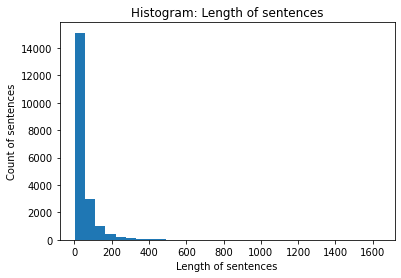

In [ ]:
num=[len(i.split()) for i in text]
plt.hist(num,bins=30)
plt.title('Histogram: Length of sentences')
plt.xlabel('Length of sentences')
plt.ylabel('Count of sentences')

- It can be observed that most of the sentences (~95%) have length of 200 words. Hence, we select max_length as 200 for all the tweets in our dataset. 
- All the sequences will be paddded to 200.
- How to decide?
If you choose too big number, then most of the positions in your sequence will have padded tokens. So choose a number near to your max lenght of text sequence

- **Preparing Textual Input**

In [ ]:
max_len=200 # This is a hyper parameter which can be tuned

- Using bert tokenizer, convert text sequences into numerical vectors

In [ ]:
# Create an empty list to save integer sequence
sent_id=[]

# iterate over each tweet and encode it using bert tokenizer
for i in notebook.tqdm(range(len(text))):
  encoded_sent=tokenizer.encode(text[i],
                                add_special_tokens=True,
                                max_length= max_len,
                                truncation=True,
                                pad_to_max_length='right'
                                )
  
  # save integer sequence to a list
  sent_id.append(encoded_sent)

  0%|          | 0/19999 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
print(text[0])

fit perfectally tottally love fit perfectally tottally love totally surround pod still fit dock station take little get use replace dock station like one clock radio etc easy get hold button dock port ear phone port thing really not really like really no protection wheel selector center button mostly want something protect screen not cheep make well


In [ ]:
print(sent_id[0])

[101, 4906, 3819, 3973, 2000, 28200, 2135, 2293, 4906, 3819, 3973, 2000, 28200, 2135, 2293, 6135, 15161, 17491, 2145, 4906, 8946, 2276, 2202, 2210, 2131, 2224, 5672, 8946, 2276, 2066, 2028, 5119, 2557, 4385, 3733, 2131, 2907, 6462, 8946, 3417, 4540, 3042, 3417, 2518, 2428, 2025, 2428, 2066, 2428, 2053, 3860, 5217, 27000, 2415, 6462, 3262, 2215, 2242, 4047, 3898, 2025, 18178, 13699, 2191, 2092, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
len(sent_id)

19999

- You can see here that '.' i.e. full stop is represented by different number (1012). 
- 101 represents CLS token and 102 represents SEP token

- Create Attention masks

In [ ]:
attention_mask=[]

for sent in sent_id:
  attn_mask=[int(token_id>0) for token_id in sent]
  attention_mask.append(attn_mask)

In [ ]:
len(attention_mask)

19999

#### Step 6: Training and Validation Data

In [ ]:
# Splitting input data
train_inputs,validation_inputs, train_labels,validation_labels=train_test_split(sent_id,labels,random_state=2018, test_size=0.1,stratify=labels)
# Splitting masks
train_mask,validation_mask,_,_= train_test_split(attention_mask,labels,random_state=2018,test_size=0.1,stratify=labels)



- For both the labels and attention mask, keeping random_state=2018 same, ensures that same indices are randomly being picked up from both the lists.
-stratify=label ensures the ratio of labels in original dataset is maintained in the train and validation set.

#### Step 7: Define Dataloaders

In [ ]:
# Converting all inputs and labels into torch tensors which is the required datatype for the BERT model

train_inputs=torch.tensor(train_inputs)
train_labels=torch.tensor(train_labels)
train_mask=torch.tensor(train_mask)

validation_inputs=torch.tensor(validation_inputs)
validation_labels=torch.tensor(validation_labels)
validation_mask=torch.tensor(validation_mask)

- In a dataset, we store indices and it's corresponding labels
- Where as in Dataloaders, an iterator is wrapped aroound the dataset so that sampling can be performed easlily (by accessing indices of rows). With the help of iterator, it is easy to iterate through the batches and understand encoded sequences.
- Basically Dataloader takes in dataset and sampler to return an iterable over dataset
- The output of DataLoader is input batch, masks batch and labels batch.
- batch_size is needed for training, and in order to fine-tune BERT on a specific task, the authors recommend a batch size of 16 or 32

In [ ]:
validation_inputs

tensor([[ 101, 2048, 3538,  ...,    0,    0,    0],
        [ 101, 2147, 2066,  ...,    0,    0,    0],
        [ 101, 2204, 2204,  ...,    0,    0,    0],
        ...,
        [ 101, 3737, 2674,  ...,    0,    0,    0],
        [ 101, 2994, 2994,  ...,    0,    0,    0],
        [ 101, 2360, 9543,  ...,    0,    0,    0]])

In [ ]:
# batch size
batch_size=32

# Creating Tensor Dataset for training data
train_data=TensorDataset(train_inputs,train_mask,train_labels)

# Defining a random sampler during training
train_sampler=RandomSampler(train_data)

# Creating iterator using DataLoader. This iterator supports batching, customized data loading order
train_dataloader=DataLoader(train_data,sampler=train_sampler,batch_size=batch_size )

# Creating tensor dataset for validation data
validation_data=TensorDataset(validation_inputs,validation_mask,validation_labels)

# Defining a sequential sampler during validation, bcz there is no need to shuffle the data. We just need to validate
validation_sampler=SequentialSampler(validation_data)

# Create an iterator over validation dataset
validation_dataloader=DataLoader(validation_data,sampler=validation_sampler,batch_size=batch_size)



In [ ]:
#validation_dataloader.next()

- Tensor Dataset: It creates dataset by combining different tensors
- DataLoader: Loads the dataset in the form of batchs
- Random Sampler: Samples batches randomly from the data loader
- Sequential Sampler: It samples the batches sequentially from the data loader

In [ ]:
# Create an iterator object
iterator=iter(train_dataloader)

# loads batch data
sent_id,mask,target=iterator.__next__()

In [ ]:
sent_id.shape

torch.Size([32, 200])

- 32 is a batch size (32 text records) and 25 is the length of sequence

In [ ]:
sent_id

tensor([[  101,  3013, 10982,  ...,     0,     0,     0],
        [  101,  2844, 10514,  ...,     0,     0,     0],
        [  101, 25933,  4371,  ...,  2028,  5080,   102],
        ...,
        [  101,  2204,  3259,  ...,  3042,  2377,   102],
        [  101,  3565,  2686,  ...,     0,     0,     0],
        [  101,  3737,  2307,  ...,     0,     0,     0]])

In [ ]:
outputs=bert(sent_id,attention_mask=mask)

In [ ]:
hidden_states=outputs[0]
CLS_hidden_state=outputs[1]

print("Shape of Hidden States:",hidden_states.shape)
print("Shape of CLS Hidden State:",CLS_hidden_state.shape)

Shape of Hidden States: torch.Size([32, 200, 768])
Shape of CLS Hidden State: torch.Size([32, 768])


In [ ]:
type(hidden_states)

torch.Tensor

#### Step 8: Fine-Tuning BERT

- The pretrained BERT model is trained on large amount of general corpus. Finetuning the pretrained model will help us capture domain specific features from our dataset.
- Here, we will fine tune only head layer. i.e. Head Layer is the dense layer added on the top of the pre-trained bert model. This layer is used for classification tasks.

### Steps to Follow

1. Turn off Gradients: This step is freezes the parameters of BERT model, so that when we fine tune the model, the parameters of BERT model are not affected, only weights of head part are affected.



In [ ]:
# turn off the gradient of all parameters

for param in bert.parameters():
  param.requires_grad=False

2. Define Model Architecture



In [ ]:
'''
# Classifier is a sub class of nn.Module from pytorch
class classifier(nn.Module):

  # define the layers and wrappers used by model
  def __init__(self,bert):
    #Constructor. 
    super(classifier,self).__init__() #using super() which is a proxy instance of super class-nn.Module to access the __init__() method of nn.Module
    # bert model
    self.bert=bert

    #dense layer 1
    self.fc1=nn.Linear(768,512) # the output of BERT has 768 and 512 can be any hyperparameter which we can tune

    #dense layer 2 (output layer)
    self.fc2=nn.Linear(512,3)   # 3 because our class label has 3 categories

    # droupout layer
    self.dropout=nn.Dropout(0.1)

    # relu activation function
    self.relu=nn.ReLU()

    #softmax activation function
    self.softmax=nn.LogSoftmax(dim=1)


  # Define the forward pass
  def forward(self,sent_id,mask):

    # pass the inputs to the model
    all_hidden_states,cls_hidden_state=self.bert(sent_id,attention_mask,return_dict=False)

    # pass CLS hidden state to dense layer
    x=self.fc1(cls_hidden_state)

    # Apply ReLU activation function
    x=self.relu(x)

    # Apply dropout
    x=self.dropout(x)

    # pass input to the output layer
    x=self.fc2(x)

    # apply softmax activation
    x=self.softmax(x)

    return x


'''

In [ ]:
class classifier(nn.Module):

    #define the layers and wrappers used by model
    def __init__(self, bert):
      
      #constructor
      super(classifier, self).__init__()

      #bert model
      self.bert = bert 

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      #dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,3)
      
      #dropout layer
      self.dropout = nn.Dropout(0.1)

      #relu activation function
      self.relu =  nn.ReLU()

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      all_hidden_states, cls_hidden_state = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
      #pass CLS hidden state to dense layer
      x = self.fc1(cls_hidden_state)

      #Apply ReLU activation function
      x = self.relu(x)

      #Apply Dropout
      x = self.dropout(x)

      #pass input to the output layer
      x = self.fc2(x)
      
      #apply softmax activation
      x = self.softmax(x)

      return x

**Why do you need dropout?**
- Dropout means randomly ignoring neurons during the training phase to reduce over fitting.
- A fully connected neural network accumulates most of the parameters and as a result, neurons develop co-dependency amongst each other during training phase. This controls the individual power of each neuron and leads to voer-fitting of training data

In [ ]:
# create the model
model=classifier(bert)

# push the model to GPU, if available
model=model.to(device)

In [ ]:
# model arcitecture
model

classifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
 

- We can see that fc1, fc2 are the 2 additional linear layers we've added to the BERT model


In [ ]:
type(sent_id)

torch.Tensor

In [ ]:
# push the tensors to GPU
sent_id=sent_id.to(device)
mask=mask.to(device)
target=target.to(device)


In [ ]:
# pass inputs to the model
outputs=model(sent_id,mask)

- The forward method is called from the __call__ function of nn.Module when we run the above line of code. 
- When the classifier class is instantiated, all the statements withi __init__() class are executed. i.e. constructor is executed.
- When we run the classifier on input data, via model(sent_id, mask) the __call__ method is invoked.
- The classifier class simply inherits the __call__ method of the nn.Module class and when we run classifier(input), the forward method is called.

In [ ]:
outputs=outputs.to(device)

In [ ]:
print(outputs)

tensor([[-1.1076, -0.9496, -1.2631],
        [-1.1393, -0.9869, -1.1802],
        [-1.1486, -0.8917, -1.2984],
        [-1.0606, -0.9406, -1.3342],
        [-1.1491, -0.9781, -1.1808],
        [-1.1499, -0.8981, -1.2874],
        [-1.1347, -0.9033, -1.2973],
        [-1.1664, -0.8929, -1.2763],
        [-1.1508, -0.9760, -1.1816],
        [-1.0739, -0.9846, -1.2561],
        [-1.1528, -0.9785, -1.1764],
        [-1.0774, -0.9531, -1.2948],
        [-1.1712, -0.9093, -1.2475],
        [-1.0865, -0.9504, -1.2874],
        [-1.1131, -1.0491, -1.1357],
        [-1.1358, -0.9177, -1.2751],
        [-1.1950, -0.9278, -1.1978],
        [-1.0935, -0.9823, -1.2361],
        [-1.1840, -0.9333, -1.2016],
        [-1.0324, -1.0320, -1.2463],
        [-1.0773, -0.9727, -1.2679],
        [-1.1800, -0.9279, -1.2128],
        [-1.1015, -1.0493, -1.1475],
        [-1.1479, -0.9860, -1.1723],
        [-1.1365, -0.9141, -1.2794],
        [-1.1699, -0.8307, -1.3710],
        [-1.0956, -0.9593, -1.2641],
 

- Now that we have defined the model arcitecture, let's see how many trainable parameters we have.
- numel() returns the total number of elemtns in input tensor. 
- If we would have trained the parameters in BERT pretrained model, then this number of trainable parameters would have been in millions.

In [ ]:
# no. of trainable parameters
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')


The model has 395,267 trainable parameters


3. Define Optimizer and Loss



In [ ]:
# Adam optmizer
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

([<matplotlib.axis.XTick at 0x7fad47bc28e0>,
 [Text(0, 0, 'Good'), Text(1, 0, 'Bad'), Text(2, 0, 'Neutral')])

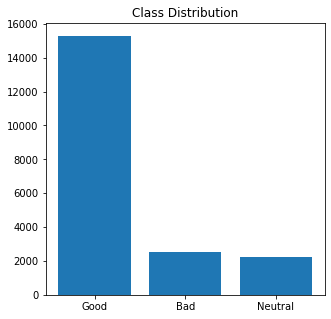

In [ ]:
# Understnding class distribution

keys=['0','1','2']

# set figure size
plt.figure(figsize=(5,5))

# plot bar chart
plt.bar(keys,class_counts)

# set title
plt.title('Class Distribution')
plt.xticks(np.arange(3),['Good','Bad','Neutral'])

In [ ]:
# library for array processing
import numpy as np

# computing the class weights
class_weights=compute_class_weight(class_weight='balanced',classes=np.unique(labels),y=labels)
print("Class Weights:",class_weights)

Class Weights: [2.66121091 0.43607859 3.0205407 ]


In [ ]:
# Converting a list of class weights into a tensor
weights=torch.tensor(class_weights, dtype=torch.float)

# transferring weights to GPU
weights=weights.to(device)

# define the loss function
cross_entropy=nn.NLLLoss(weight=weights)

In [ ]:
# Computing the loss
print(target)
#print(outputs)
loss=cross_entropy(outputs,target)
print('Loss: ',loss)

tensor([1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 2, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 2], device='cuda:0')
Loss:  tensor(1.1200, device='cuda:0', grad_fn=<NllLossBackward0>)


In [ ]:
# Function for computing time in hh:mm:ss

def format_time(elapsed):

  elapsed_rounded=int(round(elapsed))

  # format intp hh:mm:ss
  return str(datetime.timedelta(seconds=elapsed_rounded))


4. Define Train and Evaluate

The deep learning model is trained in the form of epochs where in each epoch consists of several batches. 

- During **Training Phase**, for each batch, we need to take following steps:

1. Perform Forward Pass
2. Compute Loss
3. Backpropogate Loss
4. Update Weights

- In **Evaluation Phase**, for each batch, we need to perform following steps:
1. Perform forward pass
2. Compute Loss

**Training: Epoch -> Batch -> Forward Pass -> Compute Loss -> Backpropogate Loss -> Update Weights**


**Evaluation: Epoch -> Batch -> Forward Pass -> Compute Loss**

**Epoch**
- An epoch refers to one complete pass of the training dataset through the algorithm (through the neural network)
- Number of epochs is the number of complete passes of the entire training dataset passing through the training or learning process of the algorithm.
- It is the hyper parameter that indicates number of times the learning algorithm will work through the entire dataset.

**Training Phase**

For each epoch, we have a training phase and validation phase. Hence, for each batch, we need to take following steps:
  1. Load data ontp the GPU for acceleration
  2. Unpack the data inputs and labels
  3. Clear out the gradients calculated in previous steps
  4. Forward pass (feed input data through week)
  5. Backward pass (backpropogation)
  6. Update parameters using optimizer.step()
  7. Track variables for monitoring progress

In [ ]:
# Defining a training function for the model:

def train():
  print('\n Training')

  # set the model on training phase- Dropout layers are activated
  model.train()
  # recording current time
  t0=time.time()
  # initialize the loss and accuracy to 0
  total_loss,total_accuracy=0,0

  # Create an empty list to save the model prediction
  total_preds=[]

  # for every batch
  for step, batch in enumerate(train_dataloader):
    #Progress update after every 40 batches
    if step % 40==0 and not step==0:
      elapsed=format_time(time.time()-t0)         # Calculate elapsed time in minutes
      print(' Batch{:>5,} of {:>5,}. Elapsed: {:}.'.format(step,len(train_dataloader),elapsed)) # Print progress
    batch=tuple(t.to(device) for t in batch)      # push the batch to GPU

    # batch is a part of all the records in train_dataloader. It contains 3 pytorch tensors:
    # [0]: input ids
    # [1]: attention masks
    # [2]: labels

    sent_id,mask,labels=batch

    #Pytorch doesn't automatically clear previously calculated gradients, hence before performing a backward pass, clear previous gradients
    model.zero_grad()

    # Perform a forward pass. This returns the model predictions
    preds=model(sent_id,mask)

    # Compute the loss between actual and predicted values
    loss=cross_entropy(preds,labels)

    #Accumulate training loss over all the batches, so that we can calculate the average loss at the end
    # loss is a tensor containing a single value.
    # .itme() method just returns the Python value from the tensor

    total_loss=total_loss+loss.item()

    # Perform backward pass to calculate the gradients
    loss.backward()
    # During backward pass, information about parameter changes flows backwards, from the output to the hidden layers to the input

    optimizer.step() 
    # Update parameters and take a step using the computed gradient.
    # Here, the optimizer dictates the update rule = how the parameters are modified based on their gradients, learning rate and so on.

    # The model predictions are stored on GPU, so push it to CPU
    preds=preds.detach().cpu().numpy()

    # Accumulate model predicitons of each batch
    total_preds.append(preds)

  

    # Compute the training loss of an epoch
  avg_loss=total_loss/len(train_dataloader)

  # The prediction are in the form of (no. of batches, size of batch, no. of classes)
  # So we need to resahpe the predictions in the form of number of samples x number of classes

  total_preds=np.concatenate(total_preds, axis=0)

  return avg_loss,total_preds

**Evaluation Phase**

1. Load data onto the GPU for acceleration
2. Unpack the data inputs
3. Forward Pass
4. Compute Loss on validation data]
5. Track variables for monitoring

In [ ]:
# define a function for evaluating the model

def evaluate():
  print("'n Evaluating....")

  # set the model on validation phase. Here dropout layers are deactivated
  model.eval()

  # record the current time
  t0=time.time()

  # initialize loss and accuracy to 0
  total_loss, total_accuracy=0,0

  # Create an empty list to save model predicitons
  total_preds=[]

  # for each batch

  for step, batch in enumerate(validation_dataloader):
    if step%40==0 and not step ==0:
      elapsed=format_time(time.time()-t0)
      print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(validation_dataloader), elapsed))
    
    batch=tuple(t.to(device) for t in batch)
    sent_id,mask,labels=batch
      
    #deactivate autograd
    with torch.no_grad():

      preds=model(sent_id,mask)
      loss=cross_entropy(preds,labels)
      total_loss=total_loss+loss.item()
      preds=preds.detach().cpu().numpy()
      total_preds.append(preds)
    
    avg_loss=total_loss/len(validation_dataloader)

    total_preds=np.concatenate(total_preds,axis=0)

    return avg_loss,total_preds


In [ ]:
#define a function for evaluating the model
def evaluate():
  
  print("\nEvaluating.....")
  
  #set the model on training phase - Dropout layers are deactivated
  model.eval()

  #record the current time
  t0 = time.time()

  #initialize the loss and accuracy to 0
  total_loss, total_accuracy = 0, 0
  
  #Create a empty list to save the model predictions
  total_preds = []

  #for each batch  
  for step,batch in enumerate(validation_dataloader):
    
    # Progress update every 40 batches.
    if step % 40 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(validation_dataloader), elapsed))

    #push the batch to gpu
    batch = tuple(t.to(device) for t in batch)

    #unpack the batch into separate variables
    # `batch` contains three pytorch tensors:
    #   [0]: input ids 
    #   [1]: attention masks
    #   [2]: labels        
    sent_id, mask, labels = batch

    #deactivates autograd
    with torch.no_grad():
      
      # Perform a forward pass. This returns the model predictions
      preds = model(sent_id, mask)

      #compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      # Accumulate the validation loss over all of the batches so that we can
      # calculate the average loss at the end. `loss` is a Tensor containing a
      # single value; the `.item()` function just returns the Python value 
      # from the tensor.      
      total_loss = total_loss + loss.item()

      #The model predictions are stored on GPU. So, push it to CPU
      preds=preds.detach().cpu().numpy()

      #Accumulate the model predictions of each batch
      total_preds.append(preds)

  #compute the validation loss of a epoch
  avg_loss = total_loss / len(validation_dataloader) 

  #The predictions are in the form of (no. of batches, size of batch, no. of classes).
  #So, reshaping the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds


5. Train the model


In [ ]:
# Assign the initial loss to infinite
best_valid_loss=float('inf')

# Create an empty list to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

epochs=5

#for each epoch repeat call the train() method
for epoch in range(epochs):
  print('\n ............epoch {:} / {:} .......'.format(epoch + 1, epochs))

  #train model
  train_loss,_ =train()

  #evaluate model
  valid_loss,_=evaluate()

  # save the best model
  if valid_loss<best_valid_loss:
    best_valid_loss=valid_loss
    torch.save(model.state_dict(),'Saved_weights.pt')

  # Accumulate training and validaion loss
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  print(f'\nTraining Loss: {train_loss:.3f}')
  print(f'Validation Loss: {valid_loss:.3f}')

print("")
print("Training complete!")


 ............epoch 1 / 5 .......

 Training
 Batch   40 of   563. Elapsed: 0:00:14.
 Batch   80 of   563. Elapsed: 0:00:29.
 Batch  120 of   563. Elapsed: 0:00:44.
 Batch  160 of   563. Elapsed: 0:00:59.
 Batch  200 of   563. Elapsed: 0:01:16.
 Batch  240 of   563. Elapsed: 0:01:32.
 Batch  280 of   563. Elapsed: 0:01:47.
 Batch  320 of   563. Elapsed: 0:02:02.
 Batch  360 of   563. Elapsed: 0:02:18.
 Batch  400 of   563. Elapsed: 0:02:34.
 Batch  440 of   563. Elapsed: 0:02:49.
 Batch  480 of   563. Elapsed: 0:03:05.
 Batch  520 of   563. Elapsed: 0:03:21.
 Batch  560 of   563. Elapsed: 0:03:36.

Evaluating.....
  Batch    40  of     63.    Elapsed: 0:00:15.

Training Loss: 1.071
Validation Loss: 0.979

 ............epoch 2 / 5 .......

 Training
 Batch   40 of   563. Elapsed: 0:00:16.
 Batch   80 of   563. Elapsed: 0:00:31.
 Batch  120 of   563. Elapsed: 0:00:47.
 Batch  160 of   563. Elapsed: 0:01:03.
 Batch  200 of   563. Elapsed: 0:01:18.
 Batch  240 of   563. Elapsed: 0:01:34.
 


6. Evaluate the model



In [ ]:
# load weights of best model
path='Saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
# get the model prediction on the validation data
valid_loss,preds=evaluate()
# this returns 2 elements- Validation loss and prediction
print(valid_loss)


Evaluating.....
  Batch    40  of     63.    Elapsed: 0:00:15.
0.8821669798048716


In [ ]:
# Converting the log(probabilities) into class & then choosing index of maximum value as class
y_pred=np.argmax(preds,axis=1)

# actual labels
y_true=validation_labels

In [ ]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.40      0.72      0.51       250
           1       0.90      0.81      0.85      1529
           2       0.21      0.17      0.18       221

    accuracy                           0.73      2000
   macro avg       0.50      0.56      0.52      2000
weighted avg       0.76      0.73      0.74      2000



References

- https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5

- https://www.cs.toronto.edu/~lczhang/360/lec/w03/nn.html
